In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Text Pre-Processing
from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec


# Tools for building a model
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tools for assessing the quality of model prediction
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Colab Notebooks/電影評論情緒分析'
os.chdir(data_path)

df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_path, 'test.csv'))

Mounted at /content/drive


## Data preprocessing :

#### Find the appropriate sentence length:

In [ ]:
# Can use the result as a reference for max_len
print('The mean word count in a movie review :', df['review'].apply(lambda x: len(x.split(' '))).mean())

# Also can use percentages as a reference for max_len
sentence_lengths = df['review'].apply(lambda x: len(x.split(' ')))
quantiles = np.percentile(sentence_lengths, [25, 50, 75])

print('The minimal word count in a movie review : ', min(sentence_lengths))
print('The first quantile (25%) of word count in a movie review :', quantiles[0])
print('The second quantile (50%) of word count in a movie review :', quantiles[1])
print('The third quantile (75%) of word count in a movie review :', quantiles[2])
print('The maximum word count in a movie review : ', max(sentence_lengths))


The mean word count in a movie review : 199.13876107702794
The minimal word count in a movie review :  2
The first quantile (25%) of word count in a movie review : 99.0
The second quantile (50%) of word count in a movie review : 153.0
The third quantile (75%) of word count in a movie review : 251.0
The maximum word count in a movie review :  1839


In [ ]:
# set max_len
max_len = 200

### Text Pre-Processing

* Use spaCy to Lemmatize text and store it in review_lines

Because when training Word2Vec, all words are lammatized in pre-processing, so be sure to do the same pre-processing for the data set

In [ ]:
from tqdm import tqdm
import spacy.cli
spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md', disable=["ner", "parser"])

reviews1 = df['review'].values.tolist()
df_text = list()
for review in tqdm(reviews1):
    doc = nlp(review)
    words = [word.lemma_ for word in doc]
    df_text.append(words)


reviews2 = df_test['review'].values.tolist()
test_text = list()
for review in tqdm(reviews2):
    doc = nlp(review)
    words = [word.lemma_ for word in doc]
    test_text.append(words)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


100%|██████████| 5869/5869 [01:38<00:00, 59.81it/s]


### Split train data into training set / validation set




In [ ]:
y = df['sentiment'].values
y_test = df_test['sentiment'].values

train_text, val_text, y_train, y_val = train_test_split(df_text, y, test_size=0.1, stratify=y, shuffle=True, random_state=42)

### Create a vocabulary index :

In [ ]:
# Tokenize Text
token = Tokenizer(oov_token='OOV')
token.fit_on_texts(train_text)

# Converting text to sequences
x_train_seq = token.texts_to_sequences(train_text)
x_val_seq = token.texts_to_sequences(val_text)
x_test_seq = token.texts_to_sequences(test_text)

# sequence padding
x_train = pad_sequences(x_train_seq, maxlen = max_len, padding='post')
x_val = pad_sequences(x_val_seq,  maxlen = max_len)
x_test = pad_sequences(x_test_seq,  maxlen = max_len)


## Prepare Pre-trained Word2Vec weights

### Load the pre-trained word2vec embedding weights

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=17ThJchrSwnOy1HEKX1HT79vpl1y4UH2L' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=17ThJchrSwnOy1HEKX1HT79vpl1y4UH2L" -O wiki-word2vec.zip && rm -rf /tmp/cookies.txt
!unzip wiki-word2vec.zip

--2023-10-04 14:53:41--  https://docs.google.com/uc?export=download&confirm=t&id=17ThJchrSwnOy1HEKX1HT79vpl1y4UH2L
Resolving docs.google.com (docs.google.com)... 142.251.12.113, 142.251.12.102, 142.251.12.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i9qnfqrffesfb8qtb8qcv1t5ocj0jeki/1696431150000/18293686574256102848/*/17ThJchrSwnOy1HEKX1HT79vpl1y4UH2L?e=download&uuid=7d950f58-7700-45aa-80fd-d321d6dd7e93 [following]
--2023-10-04 14:53:43--  https://doc-14-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i9qnfqrffesfb8qtb8qcv1t5ocj0jeki/1696431150000/18293686574256102848/*/17ThJchrSwnOy1HEKX1HT79vpl1y4UH2L?e=download&uuid=7d950f58-7700-45aa-80fd-d321d6dd7e93
Resolving doc-14-44-docs.googleusercontent.com (doc-14-44-docs.googleusercontent.com)... 172.217.194.132,

### Use Gensim to load the parameters you just downloaded

In [ ]:
w2v_model = Word2Vec.load("wiki-lemma-100D-phrase")

### Check the word vector

In [ ]:
w2v_model.wv.most_similar('Google', topn = 5)

[('Microsoft', 0.8559668660163879),
 ('Google_Search', 0.8424477577209473),
 ('Google_Analytics', 0.8412379026412964),
 ('Yahoo', 0.8326561450958252),
 ('AltaVista', 0.824895977973938)]

In [ ]:
# similaraity b/w two words
w2v_model.wv.similarity('winter','summer')

0.81486917

In [ ]:
w2v_model.wv['Google']

array([ 3.3885376 , -4.2511983 , -1.445084  ,  1.9302932 ,  0.84648174,
       -0.63184077,  0.05726242,  0.7063744 , -0.05059653,  2.1846352 ,
       -0.12328646,  0.6471171 ,  0.25026178, -0.14930539, -0.07820829,
        0.16145864,  0.6498362 ,  1.0886047 ,  1.5343726 ,  4.950689  ,
        0.50769436, -0.3946989 ,  2.1025164 , -3.1834273 ,  2.380777  ,
        0.24872196, -2.5802555 ,  1.4149348 ,  0.63408375, -1.6591691 ,
       -2.4389815 ,  2.1249    ,  0.39783332, -0.35228804, -2.9626958 ,
       -4.475956  , -4.0608654 , -0.39374784, -0.37150937, -1.4930124 ,
       -2.4813695 ,  2.203496  ,  1.9972353 ,  5.479271  , -0.00601585,
        2.1382024 , -1.6378103 ,  1.9081411 , -0.6341882 , -2.2414782 ,
       -0.70867395,  1.1144645 , -1.7722839 ,  0.37062666,  0.80082476,
        1.9306395 ,  0.48852623, -1.1423063 ,  3.0780652 ,  0.7570495 ,
       -2.8385687 ,  0.5158689 , -1.316193  ,  0.51292163,  1.862376  ,
        1.7524154 ,  1.8987881 ,  0.06306809,  1.378573  , -3.18

### Transfer the word2vec model under gensim into different formats (txt file)


* Since the word2vec model we just downloaded is specifically for gensim, if we want to use it for keras, we must first save the model in a different format (txt file)

In [ ]:
w2v_model.wv.save_word2vec_format('keras_word2vec.txt', binary=False)

### Create that dictionary with those embeddings :  
  


In [ ]:
embeddings_index = dict()

with open('keras_word2vec.txt') as f:
  for line in f:
    values = line.split()
    # Only accepts vectors of length 101 (word + 100d embedding)
    if len(values) != 101:
      print(values)
      continue
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

['346848', '100']
Found 346848 word vectors.


### Create a lookup table (look up table/ embedding matrix):

(Based on the results of the tokenizer above)

In [ ]:
# extracted words.
vocab = token.word_index
vocab_size = len(vocab) + 1
embed_dim = 100

# Creat a look up table
embedding_matrix = np.zeros((vocab_size, embed_dim))
for word, i in vocab.items():
	  embedding_vector = embeddings_index.get(word)
	  if embedding_vector is not None:
	    	embedding_matrix[i] = embedding_vector
        # if word is not found then embed_vector corressponding to that vector will stay zero.

## Modeling & Training


In [ ]:
# function :  Accuracy and loss for training and validation
def plot_performance(epochs, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Training and Validation Loss')
    plt.show()


# evaluate function
def evaluate(model, x_test, y_test):
  y_pred = model.predict(x_test)
  y_pred_label = (y_pred > 0.5)  # 也可寫 [1 if val > 0.5 else 0 for val in y_pred]
  print('----- Model Evaluation -----')
  print('Confusion Matrix:')
  print(confusion_matrix(y_test, y_pred_label))
  print('  ')
  print(classification_report(y_test, y_pred_label))
  print('  ')
  print('---------------------')
  print('  ')
  print('AUC: {0}'.format(roc_auc_score(y_test, y_pred_label)))
  print('F1 score: {0}'.format(f1_score(y_test, y_pred_label)))
  print('Precision: {0}'.format(precision_score(y_test, y_pred_label)))
  print('Recall: {0}'.format(recall_score(y_test, y_pred_label)))
  print('Accuracy: {0}'.format(accuracy_score(y_test, y_pred_label, normalize=True)))

### Word2vec + BiLSTM

*  Construct BiLSTM model


In [ ]:
# Define BiLSTM model
model_LSTM_1 = Sequential()
model_LSTM_1.add(Embedding(input_dim = vocab_size, output_dim = embed_dim, weights = [embedding_matrix], input_length = max_len, trainable=True))
model_LSTM_1.add(SpatialDropout1D(0.25))
model_LSTM_1.add(Bidirectional(LSTM(128, return_sequences = True)))
model_LSTM_1.add(GlobalMaxPool1D())
model_LSTM_1.add(Dropout(0.3))
model_LSTM_1.add(Dense(30, activation="relu"))
model_LSTM_1.add(Dropout(0.3))
model_LSTM_1.add(Dense(1, activation="sigmoid"))

model_LSTM_1.compile(loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss", mode='min', patience=2, restore_best_weights=True)

# model structure
#model_LSTM_1.summary()

* Training

In [ ]:
batch_size = 128
epochs = 20
history_LSTM_1 = model_LSTM_1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks = [callback])

Epoch 1/20
166/166 [==============================] - 31s 150ms/step - loss: 0.6499 - accuracy: 0.6076 - val_loss: 0.5578 - val_accuracy: 0.7151
Epoch 2/20
166/166 [==============================] - 16s 95ms/step - loss: 0.4835 - accuracy: 0.7710 - val_loss: 0.3768 - val_accuracy: 0.8399
Epoch 3/20
166/166 [==============================] - 13s 78ms/step - loss: 0.3888 - accuracy: 0.8300 - val_loss: 0.4006 - val_accuracy: 0.8143
Epoch 4/20
166/166 [==============================] - 11s 67ms/step - loss: 0.3448 - accuracy: 0.8539 - val_loss: 0.3324 - val_accuracy: 0.8620
Epoch 5/20
166/166 [==============================] - 11s 64ms/step - loss: 0.2980 - accuracy: 0.8784 - val_loss: 0.3379 - val_accuracy: 0.8595
Epoch 6/20
166/166 [==============================] - 9s 54ms/step - loss: 0.2532 - accuracy: 0.9004 - val_loss: 0.3131 - val_accuracy: 0.8688
Epoch 7/20
166/166 [==============================] - 9s 51ms/step - loss: 0.2073 - accuracy: 0.9192 - val_loss: 0.3689 - val_accuracy: 

* Accuracy and loss for training and validation

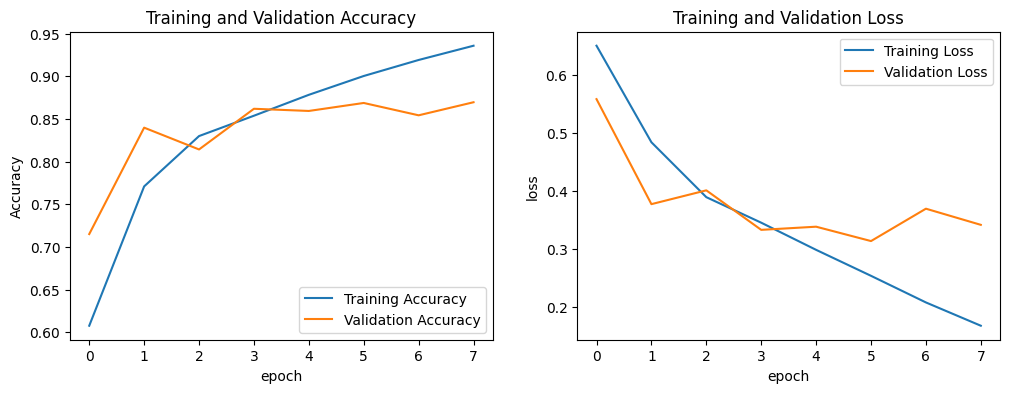

In [ ]:
plot_performance(history_LSTM_1.epoch, history_LSTM_1)

* Test data 預測/評估

In [ ]:
evaluate(model_LSTM_1, x_test, y_test)

184/184 [==============================] - 2s 7ms/step
----- Model Evaluation -----
Confusion Matrix:
[[2487  391]
 [ 356 2635]]
  
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2878
           1       0.87      0.88      0.88      2991

    accuracy                           0.87      5869
   macro avg       0.87      0.87      0.87      5869
weighted avg       0.87      0.87      0.87      5869

  
---------------------
  
AUC: 0.8725590136171777
F1 score: 0.8758517533654646
Precision: 0.8707865168539326
Recall: 0.8809762621196924
Accuracy: 0.8727210768444369
